In [36]:
import time
import torch
from torch.distributions import Categorical, kl
from d2l.torch import Animator

from net import Net
from aco import ACO
from utils import *

lr = 3e-4
EPS = 1e-10
device = 'cuda:0'

In [37]:
def train_instance(model, optimizer, n, n_ants):
    model.train()
    dist_mat, prizes, penalties = gen_inst(n, device)
    pyg_data = gen_pyg_data(prizes, penalties, dist_mat)
    heu_mat = model(pyg_data)
    heu_mat = (heu_mat / (heu_mat.min()+EPS) + EPS).reshape(n+1, n+1)
    aco = ACO(dist_mat, prizes, penalties, n_ants, heuristic=heu_mat, device=device)
    objs, log_probs = aco.sample()
    baseline = objs.mean()
    reinforce_loss = torch.sum((objs-baseline) * log_probs.sum(dim=0)) / aco.n_ants
    optimizer.zero_grad()
    reinforce_loss.backward()
    optimizer.step()

def infer_instance(model, instance, n_ants):
    model.eval()
    dist_mat, prizes, penalties, pyg_data = instance
    n = prizes.size(0)
    heu_mat = model(pyg_data)
    heu_mat = (heu_mat / (heu_mat.min()+EPS) + EPS).reshape(n, n)
    aco = ACO(dist_mat, prizes, penalties, n_ants, heuristic=heu_mat, device=device)
    objs, log_probs_list = aco.sample()
    baseline = objs.mean()
    best_sample_obj = objs.max()
    return baseline.item(), best_sample_obj.item()

In [38]:
def train_epoch(n, n_ants, steps_per_epoch, net, optimizer):
    for _ in range(steps_per_epoch):
        train_instance(net, optimizer, n, n_ants)

@torch.no_grad()
def validation(n, n_ants, epoch, net, animator=None):
    sum_bl, sum_sample_best = 0, 0
    n_val = 100
    dist_mat, prizes, penalties = gen_inst(n, device)
    pyg_data = gen_pyg_data(prizes, penalties, dist_mat)
    for _ in range(n_val):
        instance = (dist_mat, prizes, penalties, pyg_data)
        bl, sample_best = infer_instance(net, instance, n_ants)
        sum_bl += bl
        sum_sample_best += sample_best
        
    avg_bl, avg_sample_best = sum_bl/n_val, sum_sample_best/n_val
    if animator:
        animator.add(epoch+1, (avg_bl, avg_sample_best))
    
    return avg_bl, avg_sample_best

In [39]:
def train(problem_size, n_ants, steps_per_epoch, epochs):
    net = Net().to(device)
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr)
    animator = Animator(xlabel='epoch', xlim=[0, epochs],
                        legend=["Avg. sample obj.", "Best sample obj."])
    
    avg_bl, avg_best = validation(problem_size, n_ants, -1, net, animator)
    val_results = [(avg_bl, avg_best)]
    
    
    sum_time = 0
    for epoch in range(0, epochs):
        start = time.time()
        train_epoch(problem_size, n_ants, steps_per_epoch, net, optimizer)
        sum_time += time.time() - start
        avg_bl, avg_sample_best = validation(problem_size, n_ants, epoch, net, animator)
        val_results.append((avg_bl, avg_sample_best))

    print('total training duration:', sum_time)
    torch.save(net.state_dict(), f'../pretrained/pctsp/pctsp{problem_size}.pt')
    for epoch in range(-1, epochs):
        print(f'epoch {epoch}:', val_results[epoch+1])

Learn heuristic for PCTSP20:

total training duration: 38.60237503051758
epoch -1: (9.155011959075928, 11.743640403747559)
epoch 0: (5.688303699493408, 7.428920316696167)
epoch 1: (4.15192010641098, 5.010315918922425)
epoch 2: (3.835515718460083, 4.686528549194336)
epoch 3: (3.8647081637382508, 4.437800800800323)
epoch 4: (4.357136378288269, 4.974456853866577)


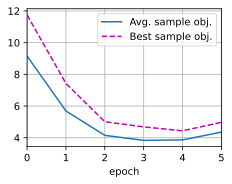

In [40]:
n_node, n_ants = 20, 20
steps_per_epoch = 64
epochs = 5
train(n_node, n_ants, steps_per_epoch, epochs)

Learn heuristic for PCTSP100:

total training duration: 75.59311628341675
epoch -1: (42.21253776550293, 53.88157131195069)
epoch 0: (34.653166885375974, 45.9852564239502)
epoch 1: (18.148210010528565, 23.531624660491943)
epoch 2: (10.307190008163452, 12.535279588699341)
epoch 3: (9.038287801742554, 10.230554733276367)
epoch 4: (8.352800092697144, 9.557615613937378)


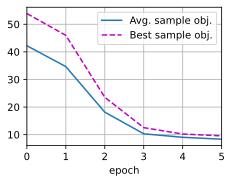

In [41]:
n_node, n_ants = 100, 20
steps_per_epoch = 64
epochs = 5
train(n_node, n_ants, steps_per_epoch, epochs)

Learn heuristic for PCTSP500:

total training duration: 621.5087370872498
epoch -1: (199.3891636657715, 256.43848373413084)
epoch 0: (101.60021835327149, 133.93580894470216)
epoch 1: (45.30628753662109, 62.345018577575686)
epoch 2: (24.483425312042236, 26.80738775253296)
epoch 3: (23.793241634368897, 25.829241313934325)
epoch 4: (20.81535276412964, 24.131171703338623)


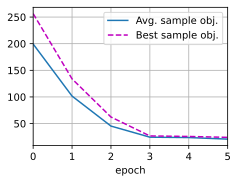

In [42]:
n_node, n_ants = 500, 20
steps_per_epoch = 128
epochs = 5
train(n_node, n_ants, steps_per_epoch, epochs)